In [1]:
# DATA PREPROCESSING
import numpy as np
from citylearn.data import DataSet

dataset_name = 'citylearn_challenge_2023_phase_3_3'

schema = DataSet.get_schema(dataset_name)
random_seed = 42
np.random.seed(random_seed)

buildings = list(schema['buildings'].keys())
# buildings = np.random.choice(buildings, size=6, replace=False).tolist()

print("Active buuldings in the schema: ")
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['include'] = True
        print(building)
    else:
        schema['buildings'][building]['include'] = False


print("\n\nActive observations in the schema: ")
active_observations = 'all'
for observation in schema['observations']:
    if active_observations == 'all':
        schema['observations'][observation]['active'] = True
        schema['observations'][observation]['shared_in_central_agent'] = True
        print(observation)
    else:
        if observation in active_observations:
            schema['observations'][observation]['active'] = True
            schema['observations'][observation]['shared_in_central_agent'] = True
            print(observation)
        else:
            schema['observations'][observation]['active'] = False
            schema['observations'][observation]['shared_in_central_agent'] = False

print("\n\nActive actions in the schema: ")
for action in schema['actions']:
    if schema['actions'][action]['active']:
        print(action)

# active_actions = 'all'
# for action in schema['actions']:
#     if active_actions == 'all':
#         schema['actions'][action]['active'] = True
#         print(action)
#     else:
#         if action in active_actions:
#             schema['actions'][action]['active'] = True
#             print(action)
#         else:
#             schema['actions'][action]['active'] = False

schema['simulation_start_time_step'] = 1
lenght_of_simulation_in_days = 7
schema['simulation_end_time_step'] = lenght_of_simulation_in_days * 24

schema['reward_function']['type'] = "citylearn.reward_function.ComfortReward"

print("\n\nReward function: ")
print(schema['reward_function']['type'])
number_of_episodes = 5

Active buuldings in the schema: 
Building_1
Building_2
Building_3
Building_4
Building_5
Building_6


Active observations in the schema: 
month
day_type
hour
daylight_savings_status
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
average_unmet_cooling_setpoint_difference
indoor_relative_humidity
non_shiftable_load
solar_generation
cooling_storage_soc
heating_storage_soc
dhw_storage_soc
electrical_storage_soc
net_electric

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

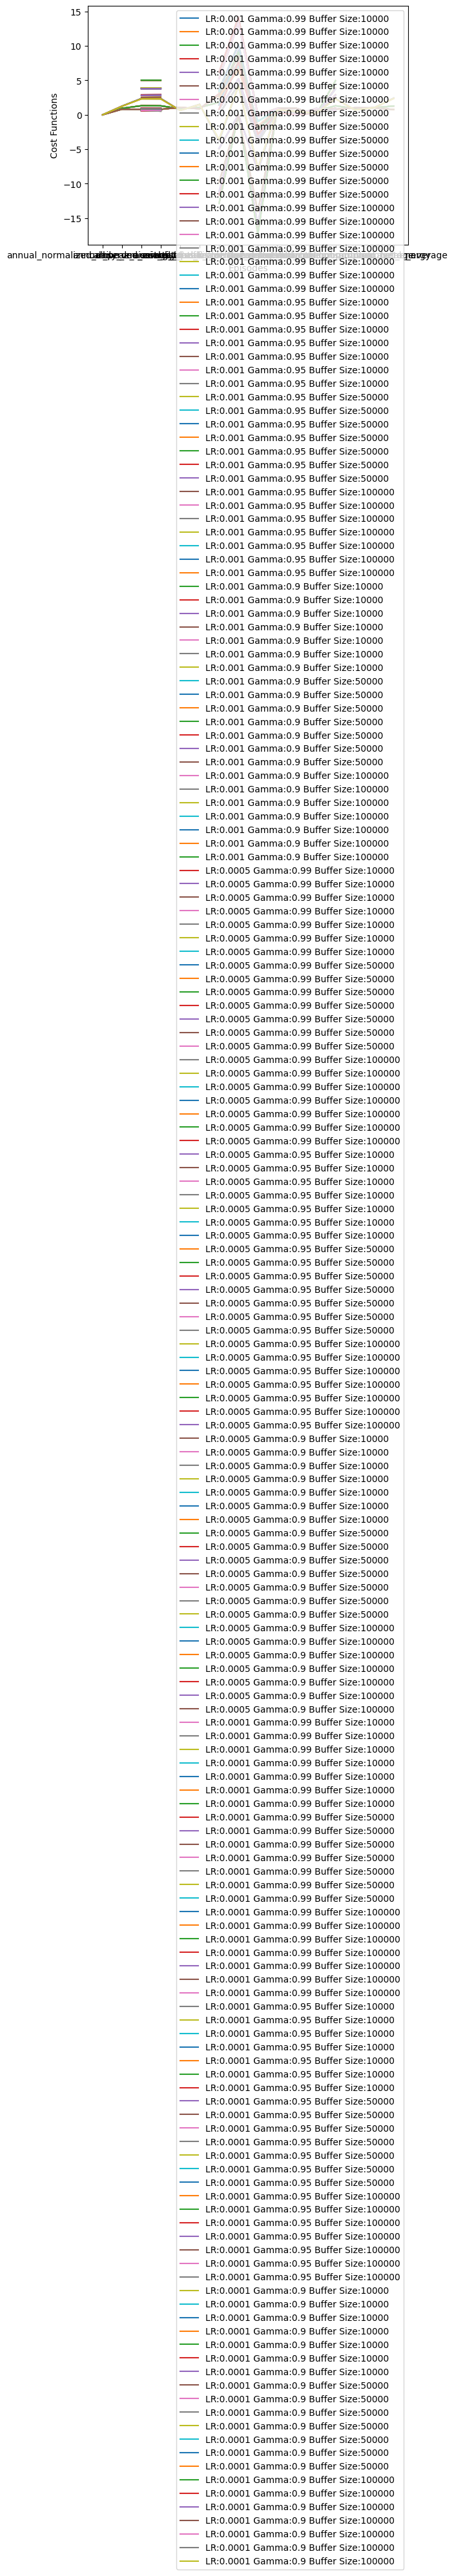

In [3]:
%reload_ext autoreload
from stable_baselines3.sac import SAC
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from helpers.custom_callback import CustomCallback
import matplotlib.pyplot as plt

%matplotlib inline


sac_env = CityLearnEnv(schema, central_agent=True)
sac_env = NormalizedObservationWrapper(sac_env)
sac_env = StableBaselines3Wrapper(sac_env)

learning_rates = [0.001, 0.0005, 0.0001]
discount_factors = [0.99, 0.95, 0.90]
replay_buffer_sizes = [10000, 50000, 100000]

# Initialize lists to store results
results = []
count = 0

# Loop through combinations of hyperparameters
for lr in learning_rates:
    for gamma in discount_factors:
        for buffer_size in replay_buffer_sizes:
            # Initialize the SAC model with current hyperparameters
            sac_model = SAC("MlpPolicy", sac_env, seed=random_seed, learning_rate=lr, gamma=gamma, buffer_size=buffer_size)

            # Calculate total timesteps
            total_timesteps = number_of_episodes * (sac_env.time_steps - 1)
            
            # Initialize callback
            sac_callback = CustomCallback(sac_env, total_timesteps=total_timesteps)

            # Train the SAC model
            sac_model.learn(total_timesteps=total_timesteps, callback=sac_callback)

            observations = sac_env.reset()

            while not sac_env.done:
                actions, _ = sac_model.predict(observations, deterministic=True)
                observations, _, _, _ = sac_env.step(actions)

            # Evaluate the model and store results
            kpis = sac_env.evaluate()
            kpis = kpis.pivot(index='cost_function', columns='name', values='value')
            kpis = kpis.dropna(how='all')
            results.append({
                'learning_rate': lr,
                'discount_factor': gamma,
                'replay_buffer_size': buffer_size,
                'kpis': kpis,
                'callback': sac_callback
            })

{'learning_rate': 0.001, 'discount_factor': 0.99, 'replay_buffer_size': 10000, 'kpis': name                                     Building_1  Building_2  Building_3  \
cost_function                                                                 
annual_normalized_unserved_energy_total    0.000000    0.000000    0.000000   
annual_peak_average                             NaN         NaN         NaN   
carbon_emissions_total                     0.787058    0.845152    3.903782   
cost_total                                 0.785406    0.831295    3.911334   
daily_one_minus_load_factor_average             NaN         NaN         NaN   
daily_peak_average                              NaN         NaN         NaN   
discomfort_delta_average                   3.803253    1.408474   -4.912882   
discomfort_delta_maximum                   7.481091    9.246672    0.000004   
discomfort_delta_minimum                  -0.963158   -2.826351   -8.116911   
discomfort_proportion                      0

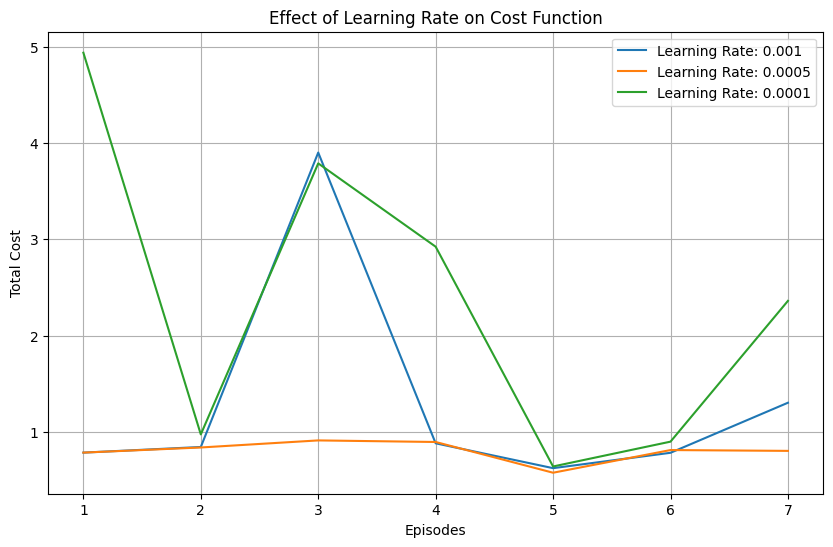

[{'learning_rate': 0.001, 'discount_factor': 0.99, 'replay_buffer_size': 10000, 'kpis': name                                     Building_1  Building_2  Building_3  \
cost_function                                                                 
annual_normalized_unserved_energy_total    0.000000    0.000000    0.000000   
annual_peak_average                             NaN         NaN         NaN   
carbon_emissions_total                     0.787058    0.845152    3.903782   
cost_total                                 0.785406    0.831295    3.911334   
daily_one_minus_load_factor_average             NaN         NaN         NaN   
daily_peak_average                              NaN         NaN         NaN   
discomfort_delta_average                   3.803253    1.408474   -4.912882   
discomfort_delta_maximum                   7.481091    9.246672    0.000004   
discomfort_delta_minimum                  -0.963158   -2.826351   -8.116911   
discomfort_proportion                      

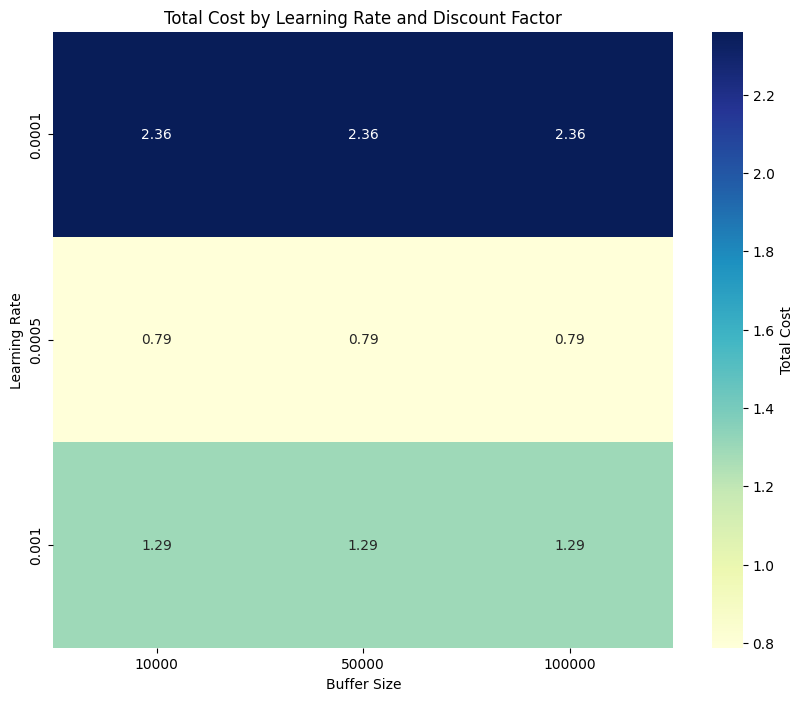

In [18]:
import seaborn as sns
import pandas as pd

gamma = 0.99

# Filter results based on constant gamma and buffer size
filtered_results = [result for result in results if result['discount_factor'] == gamma]

print(filtered_results)

# Prepare data for heatmap
data = {
    'Learning Rate': [],
    'Buffer Size': [],
    'Total Cost': []
}

for result in filtered_results:
    learning_rate = result['learning_rate']
    discount_factor = result['discount_factor']
    buffer_size = result['replay_buffer_size']
    total_cost = result['kpis'].loc['cost_total'].iloc[-1]  # Get the final total cost value
    data['Learning Rate'].append(learning_rate)
    data['Buffer Size'].append(buffer_size)
    data['Total Cost'].append(total_cost)

# Create DataFrame from the data
df = pd.DataFrame(data)

# Aggregate the data (e.g., using mean total cost) for each unique combination of learning rate and discount factor
agg_df = df.groupby(['Learning Rate', 'Buffer Size']).mean().reset_index()

# Pivot the DataFrame to create the heatmap
heatmap_data = agg_df.pivot('Learning Rate', 'Buffer Size', 'Total Cost')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Total Cost'})
plt.title('Total Cost by Learning Rate and Discount Factor')
plt.xlabel('Buffer Size')
plt.ylabel('Learning Rate')
plt.show()